In [1]:
#pip install pyspark

In [2]:
#conda install -c cyclus java-jdk

In [3]:
#pip install py4j

In [4]:
#load pySpark modules 
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql import functions as F
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf
from pyspark.sql.types import *
from pyspark.sql.functions import *
import time
spark = SparkSession.builder.getOrCreate()
spark = SparkSession.builder \
    .master('local[*]') \
    .config("spark.driver.memory", "30g") \
    .config('spark.executor.memory=30g')\
    .appName('final') \
    .getOrCreate()
sc=spark.sparkContext

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/05/06 12:26:40 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
#load flight data file into pySpark dataFrame format

flight = spark.read.csv("flights.csv", inferSchema=True, header=True)
airports = spark.read.csv("airports.csv", inferSchema=True, header=True)
flight.show(5)
airports.show(5)


+----------+---------+-------+---------------+-------------+--------+--------+
|DayofMonth|DayOfWeek|Carrier|OriginAirportID|DestAirportID|DepDelay|ArrDelay|
+----------+---------+-------+---------------+-------------+--------+--------+
|        19|        5|     DL|          11433|        13303|      -3|       1|
|        19|        5|     DL|          14869|        12478|       0|      -8|
|        19|        5|     DL|          14057|        14869|      -4|     -15|
|        19|        5|     DL|          15016|        11433|      28|      24|
|        19|        5|     DL|          11193|        12892|      -6|     -11|
+----------+---------+-------+---------------+-------------+--------+--------+
only showing top 5 rows

+----------+-----------+-----+--------------------+
|airport_id|       city|state|                name|
+----------+-----------+-----+--------------------+
|     10165|Adak Island|   AK|                Adak|
|     10299|  Anchorage|   AK|Ted Stevens Ancho...|
|   

In [6]:
df_dis = flight.distinct()
df_f = df_dis.select('DayofMonth','DayOfWeek','Carrier','OriginAirportID','DestAirportID','DepDelay',((col("ArrDelay") > 15).cast("Int").alias("label")))
df_f = df_f.withColumnRenamed("label", "trueLabel")
df_f.show(5)

+----------+---------+-------+---------------+-------------+--------+---------+
|DayofMonth|DayOfWeek|Carrier|OriginAirportID|DestAirportID|DepDelay|trueLabel|
+----------+---------+-------+---------------+-------------+--------+---------+
|         6|        1|     WN|          10821|        10140|       1|        0|
|         8|        1|     AA|          11298|        10140|       0|        0|
|        15|        1|     WN|          14747|        10140|      -6|        0|
|        27|        1|     AA|          11298|        10140|     113|        1|
|         7|        2|     OO|          12266|        10140|      -3|        0|
+----------+---------+-------+---------------+-------------+--------+---------+
only showing top 5 rows



In [7]:
df_dis.count()

2696657

### Define the Pipeline and split the data 

In [8]:
from pyspark.ml.feature import VectorAssembler, StringIndexer, VectorIndexer, MinMaxScaler
strIdx = StringIndexer(inputCol = "Carrier", outputCol = "CarrierIdx")
catVect = VectorAssembler(inputCols = ["CarrierIdx", "DayofMonth", "DayOfWeek", "OriginAirportID", "DestAirportID"], outputCol="catFeatures")
catIdx = VectorIndexer(inputCol = catVect.getOutputCol(), outputCol = "CatFeatures")
numVect = VectorAssembler(inputCols = ["DepDelay"], outputCol="numFeatures")
minMax = MinMaxScaler(inputCol = numVect.getOutputCol(), outputCol="normFeatures")
featVect = VectorAssembler(inputCols=["CatFeatures", "normFeatures"], outputCol="features")
label_stringIdx = StringIndexer(inputCol = 'trueLabel', outputCol = 'label')
train, test = df_f.randomSplit([0.8, 0.2], seed = 2018)


### build the logistic regression model

In [26]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
lr = LogisticRegression(labelCol="label",featuresCol="features",maxIter=10,regParam=0.3)

pipeline = Pipeline(stages=[strIdx, catVect, catIdx, numVect, minMax, featVect,label_stringIdx, lr])
#train the model
t1 = time.time()
lrmodel = pipeline.fit(train)
t2 = time.time()
print(t2-t1)

22/05/06 16:37:56 WARN MemoryStore: Not enough space to cache rdd_3697_3 in memory! (computed 17.0 MiB so far)
22/05/06 16:37:56 WARN BlockManager: Persisting block rdd_3697_3 to disk instead.


72.96954226493835


#### Make predictions on the test set

In [27]:
predictions = lrmodel.transform(test)
predictions_lr = predictions.select("features", "prediction", "trueLabel")
predictions_lr.show(5)
predictions.show(5)

+--------------------+----------+---------+
|            features|prediction|trueLabel|
+--------------------+----------+---------+
|[10.0,1.0,0.0,103...|       0.0|        0|
|[10.0,1.0,0.0,104...|       0.0|        0|
|[10.0,1.0,0.0,107...|       0.0|        0|
|[10.0,1.0,0.0,107...|       0.0|        1|
|[10.0,1.0,0.0,107...|       0.0|        0|
+--------------------+----------+---------+
only showing top 5 rows



+----------+---------+-------+---------------+-------------+--------+---------+----------+--------------------+-----------+--------------------+--------------------+-----+--------------------+--------------------+----------+
|DayofMonth|DayOfWeek|Carrier|OriginAirportID|DestAirportID|DepDelay|trueLabel|CarrierIdx|         CatFeatures|numFeatures|        normFeatures|            features|label|       rawPrediction|         probability|prediction|
+----------+---------+-------+---------------+-------------+--------+---------+----------+--------------------+-----------+--------------------+--------------------+-----+--------------------+--------------------+----------+
|         1|        1|     9E|          10397|        10693|      -2|        0|      10.0|[10.0,1.0,0.0,103...|     [-2.0]|[0.03167185877466...|[10.0,1.0,0.0,103...|  0.0|[1.57973331259054...|[0.82916674522115...|       0.0|
|         1|        1|     9E|          10423|        13487|      -6|        0|      10.0|[10.0,1.0,

#### Evaluate our Logistic Regression model.

In [28]:
#Evaluating prediction results

tp = float(predictions.filter("prediction == 1.0 AND label == 1").count())
fp = float(predictions.filter("prediction == 1.0 AND label == 0").count())
tn = float(predictions.filter("prediction == 0.0 AND label == 0").count())
fn = float(predictions.filter("prediction == 0.0 AND label == 1").count())
pr = tp / (tp + fp)
re = tp / (tp + fn)
metrics = spark.createDataFrame([
 ("TP", tp),
 ("FP", fp),
 ("TN", tn),
 ("FN", fn),
 ("Precision", pr),
 ("Recall", re),
 ("F1", 2*pr*re/(re+pr))],["metric", "value"])
metrics.show()

+---------+-------------------+
|   metric|              value|
+---------+-------------------+
|       TP|            12875.0|
|       FP|               47.0|
|       TN|           431408.0|
|       FN|            94515.0|
|Precision| 0.9963627921374401|
|   Recall|0.11989012012291647|
|       F1|0.21402686348826383|
+---------+-------------------+



In [29]:
#Evaluate our Logistic Regression model.
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(labelCol="trueLabel", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
print('AUC = ', evaluator.evaluate(predictions))

AUC =  0.9219901873922692


In [30]:
from sklearn import metrics
actual =predictions.select('label').toPandas()
predicted = predictions.select('prediction').toPandas()
accuracy = metrics.accuracy_score(actual, predicted)
print('accuracy = ', accuracy)

accuracy =  0.8245098312130575


/var/folders/gw/yh0lqvkx31988_00fxgrp7680000gn/T/ipykernel_13901/485393531.py:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0,1], [0,1], 'k--', color='orange')


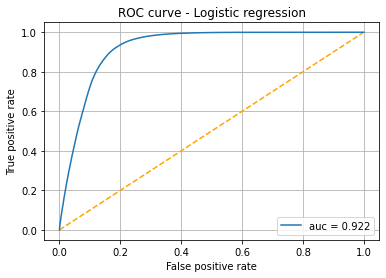

In [31]:
import numpy as np
import matplotlib.pyplot as plt
pred_pd_full = predictions.select(['label', 'prediction', 'probability']).toPandas()
pred_pd_full['probability'] = pred_pd_full['probability'].map(lambda x: list(x))
pred_pd_full['encoded_label'] = pred_pd_full['label'].map(lambda x: np.eye(2)[int(x)])

y_pred = np.array(pred_pd_full['probability'].tolist())
y_true = np.array(pred_pd_full['encoded_label'].tolist())
from sklearn.metrics import auc, roc_curve
fpr, tpr, threshold = roc_curve(y_score=y_pred[:,0], y_true=y_true[:,0])
auc = auc(fpr, tpr)


plt.plot([0,1], [0,1], 'k--', color='orange')
plt.plot(fpr, tpr, label='auc = {:.3f}'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - Logistic regression')
plt.legend(loc='lower right')
plt.grid()
plt.show()

### Tune Parameters

In [15]:
import time
t1 = time.time()
paramGrid = ParamGridBuilder().addGrid(lr.regParam, [0.3, 0.1]).addGrid(lr.maxIter, [10, 5]).addGrid(lr.threshold, 
                                                                                            [0.4, 0.3]).build()
cv = CrossValidator(estimator=pipeline, evaluator=BinaryClassificationEvaluator(), estimatorParamMaps=paramGrid, 
                    numFolds=2)

model = cv.fit(train)
t2 = time.time()
print(t2-t1)

KeyboardInterrupt: 

In [ ]:
%%time
model = cv.fit(train)

In [ ]:
newprediction = model.transform(test)
newPredicted = newprediction.select("features", "prediction", "trueLabel")
newPredicted.show(5)

In [ ]:
# Recalculate confusion matrix
tp2 = float(newprediction.filter("prediction == 1.0 AND truelabel == 1").count())
fp2 = float(newprediction.filter("prediction == 1.0 AND truelabel == 0").count())
tn2 = float(newprediction.filter("prediction == 0.0 AND truelabel == 0").count())
fn2 = float(newprediction.filter("prediction == 0.0 AND truelabel == 1").count())
pr2 = tp2 / (tp2 + fp2)
re2 = tp2 / (tp2 + fn2)
metrics2 = spark.createDataFrame([
 ("TP", tp2),
 ("FP", fp2),
 ("TN", tn2),
 ("FN", fn2),
 ("Precision", pr2),
 ("Recall", re2),
 ("F1", 2*pr2*re2/(re2+pr2))],["metric", "value"])
metrics2.show()

In [ ]:
# Recalculate the Area Under ROC
evaluator2 = BinaryClassificationEvaluator(labelCol="trueLabel", rawPredictionCol="prediction", metricName="areaUnderROC")
aur2 = evaluator.evaluate(newprediction)
print( "AUR2 = ", aur2)

In [ ]:
actual =newprediction.select('label').toPandas()
predicted = newprediction.select('prediction').toPandas()
accuracy_new = metrics.accuracy_score(actual, predicted)
print('accuracy = ', accuracy)

### split the datasize in different ratio

In [32]:
train5, test5 = df_f.randomSplit([0.5, 0.5], seed = 2000)
train6, test6 = df_f.randomSplit([0.5, 0.5], seed = 2001)
train7, test7 = df_f.randomSplit([0.5, 0.5], seed = 2002)
train9, test9 = df_f.randomSplit([0.5, 0.5], seed = 2003)

In [33]:
#train the model
t1 = time.time()
lrmodel = pipeline.fit(train5)
t2 = time.time()
print(t2-t1)
#predict the model
predictions5 = lrmodel.transform(test5)
#evaluate the model
tp = float(predictions5.filter("prediction == 1.0 AND label == 1").count())
fp = float(predictions5.filter("prediction == 1.0 AND label == 0").count())
tn = float(predictions5.filter("prediction == 0.0 AND label == 0").count())
fn = float(predictions5.filter("prediction == 0.0 AND label == 1").count())
pr = tp / (tp + fp)
re = tp / (tp + fn)
metrics = spark.createDataFrame([
 ("TP", tp),
 ("FP", fp),
 ("TN", tn),
 ("FN", fn),
 ("Precision", pr),
 ("Recall", re),
 ("F1", 2*pr*re/(re+pr))],["metric", "value"])
metrics.show()
#evaluate AUC
evaluator = BinaryClassificationEvaluator(labelCol="trueLabel", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
print('AUC = ', evaluator.evaluate(predictions5))


22/05/06 16:40:47 WARN MemoryStore: Not enough space to cache rdd_3900_3 in memory! (computed 17.0 MiB so far)
22/05/06 16:40:47 WARN BlockManager: Persisting block rdd_3900_3 to disk instead.


60.79233694076538


+---------+-------------------+
|   metric|              value|
+---------+-------------------+
|       TP|            31663.0|
|       FP|              143.0|
|       TN|          1079344.0|
|       FN|           237095.0|
|Precision| 0.9955039929573036|
|   Recall|0.11781230698248982|
|       F1|0.21069056839807826|
+---------+-------------------+



AUC =  0.9227145807138434


In [34]:
#train the model
t1 = time.time()
lrmodel = pipeline.fit(train6)
t2 = time.time()
print(t2-t1)
#predict the model
predictions6 = lrmodel.transform(test6)
#evaluate the model
tp = float(predictions6.filter("prediction == 1.0 AND label == 1").count())
fp = float(predictions6.filter("prediction == 1.0 AND label == 0").count())
tn = float(predictions6.filter("prediction == 0.0 AND label == 0").count())
fn = float(predictions6.filter("prediction == 0.0 AND label == 1").count())
pr = tp / (tp + fp)
re = tp / (tp + fn)
metrics = spark.createDataFrame([
 ("TP", tp),
 ("FP", fp),
 ("TN", tn),
 ("FN", fn),
 ("Precision", pr),
 ("Recall", re),
 ("F1", 2*pr*re/(re+pr))],["metric", "value"])
metrics.show()
#evaluate AUC
evaluator = BinaryClassificationEvaluator(labelCol="trueLabel", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
print('AUC = ', evaluator.evaluate(predictions6))


60.16779589653015


+---------+-------------------+
|   metric|              value|
+---------+-------------------+
|       TP|            31614.0|
|       FP|              131.0|
|       TN|          1078741.0|
|       FN|           237836.0|
|Precision| 0.9958733658843912|
|   Recall|0.11732789014659492|
|       F1|0.20992380351599466|
+---------+-------------------+



AUC =  0.9227780956708347


In [35]:
#train the model
t1 = time.time()
lrmodel = pipeline.fit(train7)
t2 = time.time()
print(t2-t1)
#predict the model
predictions7 = lrmodel.transform(test7)
#evaluate the model
tp = float(predictions7.filter("prediction == 1.0 AND label == 1").count())
fp = float(predictions7.filter("prediction == 1.0 AND label == 0").count())
tn = float(predictions7.filter("prediction == 0.0 AND label == 0").count())
fn = float(predictions7.filter("prediction == 0.0 AND label == 1").count())
pr = tp / (tp + fp)
re = tp / (tp + fn)
metrics = spark.createDataFrame([
 ("TP", tp),
 ("FP", fp),
 ("TN", tn),
 ("FN", fn),
 ("Precision", pr),
 ("Recall", re),
 ("F1", 2*pr*re/(re+pr))],["metric", "value"])
metrics.show()
#evaluate AUC
evaluator = BinaryClassificationEvaluator(labelCol="trueLabel", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
print('AUC = ', evaluator.evaluate(predictions7))

62.139474868774414


+---------+-------------------+
|   metric|              value|
+---------+-------------------+
|       TP|            31996.0|
|       FP|              123.0|
|       TN|          1079378.0|
|       FN|           236657.0|
|Precision| 0.9961704909866435|
|   Recall|0.11909786974275366|
|       F1|0.21275916641176704|
+---------+-------------------+



AUC =  0.9230522555843137


In [36]:
#train the model
t1 = time.time()
lrmodel = pipeline.fit(train9)
t2 = time.time()
print(t2-t1)
#predict the model
predictions9 = lrmodel.transform(test9)
#evaluate the model
tp = float(predictions9.filter("prediction == 1.0 AND label == 1").count())
fp = float(predictions9.filter("prediction == 1.0 AND label == 0").count())
tn = float(predictions9.filter("prediction == 0.0 AND label == 0").count())
fn = float(predictions9.filter("prediction == 0.0 AND label == 1").count())
pr = tp / (tp + fp)
re = tp / (tp + fn)
metrics = spark.createDataFrame([
 ("TP", tp),
 ("FP", fp),
 ("TN", tn),
 ("FN", fn),
 ("Precision", pr),
 ("Recall", re),
 ("F1", 2*pr*re/(re+pr))],["metric", "value"])
metrics.show()
#evaluate AUC
evaluator = BinaryClassificationEvaluator(labelCol="trueLabel", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
print('AUC = ', evaluator.evaluate(predictions9))

58.978029012680054


+---------+-------------------+
|   metric|              value|
+---------+-------------------+
|       TP|            31913.0|
|       FP|              122.0|
|       TN|          1079501.0|
|       FN|           236651.0|
|Precision| 0.9961916653660059|
|   Recall|  0.118828286739846|
|       F1|0.21232938233327456|
+---------+-------------------+



AUC =  0.9231346099678518


In [37]:
from sklearn import metrics
actual5 =predictions5.select('label').toPandas()
predicted5 = predictions5.select('prediction').toPandas()
accuracy5 = metrics.accuracy_score(actual5, predicted5)
print('accuracy = ', accuracy5)

accuracy =  0.8240393993673256


In [39]:
#evaluate accuracy
actual6 =predictions6.select('label').toPandas()
predicted6 = predictions6.select('prediction').toPandas()
accuracy6= metrics.accuracy_score(actual6, predicted6)
print('accuracy6 = ', accuracy6)

accuracy6 =  0.8235087760935444


In [40]:
#evaluate accuracy
actual7 =predictions7.select('label').toPandas()
predicted7 = predictions7.select('prediction').toPandas()
accuracy7 = metrics.accuracy_score(actual7, predicted7)
print('accuracy7 = ', accuracy7)

accuracy7 =  0.8243672458784382


In [41]:
#evaluate accuracy
actual9 =predictions9.select('label').toPandas()
predicted9 = predictions9.select('prediction').toPandas()
accuracy9 = metrics.accuracy_score(actual9, predicted9)
print('accuracy9 = ', accuracy9)

accuracy9 =  0.8243767370550228


In [ ]:
#sc.stop()